In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import glob
from IPython.display import clear_output
import rasterstats

In [7]:
# Set up variables, etc.

#### User needs to modify this line to correspond to their local data, which can be downloaded from Hydroshare:
#### http://www.hydroshare.org/resource/dbf8e4c2a39a4c228db867b04f9c21ed
LOC_DATA_DIR = "./2023_nwm_cnn_california/"

loc_max_daily_nwmcnn = f"{LOC_DATA_DIR}NWM-CNN_predictions/v01_daily_max/"
loc_huc_shp = f"{LOC_DATA_DIR}shapefile/WBD_18_HU2_Shape/Shape/"
loc_max_daily_huc8 = f"{LOC_DATA_DIR}csv_files/NWM-CNN_mean_huc8"
loc_max_daily_huc6 = f"{LOC_DATA_DIR}csv_files/NWM-CNN_mean_huc6"
do_huc_raster_stats = True

In [8]:
def do_raster_stats_from_nwmcnn_on_HUC(
    str_hucz,
    str_loc_raster,
    main_data_dir,
    dict_shapefiles,
    str_statz="mean",
    verbose=True,
):
    """Makes a CSV of NWM-CNN summaries onto HUCs from a HUC shapefile
    Args:
        str_hucz (str): The huc scale for the raster stats (huc6, huc8, etc.).
        str_loc_raster (str): The locaiton of the raster file that will be summarized.
        main_data_dir (str): the location of the project data, has rasters, csv files saved here.
        dict_shapefiles (dictionary): A dictionary of HUC shapefiles.
        str_statz (str, defaults to "mean"): The value which to summarze nwm-cnn over the shapefile.
        verbose (bool, defaults to True): Just in case printouts are desired.
    Saves:
        A single CSV file with HUC IDs and their associated NWM-CNN statistic
    """

    str_date = str_loc_raster.split("/")[-1].split(".tif")[0]
    str_loc_csv = f"{main_data_dir}/csv_files/NWM-CNN_{str_statz}_{str_hucz}"

    geometry = dict_shapefiles[str_hucz]["geometry"]
    idz = dict_shapefiles[str_hucz][str_hucz]

    if verbose:
        print(str_loc_raster)
        print(str_date)

    zs_data = rasterstats.zonal_stats(
        vectors=geometry, raster=str_loc_raster, stats=str_statz, nodata=255
    )
    zs_df = pd.DataFrame(zs_data)[str_statz]
    zs_df = pd.DataFrame(index=idz, data={"mean_ffa": zs_df.values})
    # Note that there needs to be a directory setup for these csv files to go.
    zs_df.to_csv(f"{str_loc_csv}/cal2023_{str_date}_{str_statz}_{str_hucz}.csv")

    if verbose:
        print("...zonal stats csv is written")

In [9]:
# get a list of those images
list_max_daily_nwmcnn_all = glob.glob(f'{loc_max_daily_nwmcnn}/*.tif')
list_max_daily_nwmcnn = []
for i in list_max_daily_nwmcnn_all:
    str_date = i.split("/")[-1].split(".tif")[0]
    try:
        if int(str_date[:4]) == 2023:
            list_max_daily_nwmcnn.append(i)
        elif int(str_date[:4]) == 2022 and int(str_date[4:6]) >= 10:
            list_max_daily_nwmcnn.append(i)
    except:
        continue

shp_huc6 = gpd.read_file(f"{loc_huc_shp}WBDHU6.shp")
shp_huc8 = gpd.read_file(f"{loc_huc_shp}WBDHU8.shp")
huc6_ids = shp_huc6["huc6"]
huc8_ids = shp_huc8["huc8"]
dict_shapefiles = {"huc6": shp_huc6, "huc8": shp_huc8}

In [10]:
# loop through the images and get the sum over HUC region
if do_huc_raster_stats:
    for hux in ["huc6", "huc8"]:
        for raster_nwmcnn in list_max_daily_nwmcnn:
            do_raster_stats_from_nwmcnn_on_HUC(
                                            str_hucz = hux, 
                                            str_loc_raster = raster_nwmcnn, 
                                            main_data_dir = LOC_DATA_DIR,
                                            dict_shapefiles=dict_shapefiles, 
                                            str_statz="mean", 
                                            verbose=False)
            clear_output


In [11]:
list_max_daily_nwmcnn_huc6 = glob.glob(f'{loc_max_daily_huc6}/*.csv')
list_max_daily_nwmcnn_huc8 = glob.glob(f'{loc_max_daily_huc8}/*.csv')

In [12]:
# --------------------------------- # -------------------------------- #
df_huc8_nwmcnn_ts = pd.DataFrame()
for max_daily_nwmcnn_huc8 in list_max_daily_nwmcnn_huc8:
    str_date = max_daily_nwmcnn_huc8.split("/")[-1].split(".csv")[0].split("_")[1]
    str_year = str_date[:4]
    str_month = str_date[4:6]
    str_day = str_date[6:8]
    datetime64 = np.datetime64(f"{str_year}-{str_month}-{str_day}")
    with open(max_daily_nwmcnn_huc8, "r") as f:
        df = pd.read_csv(f)
    for row,col in df.iterrows():
        df_huc8_nwmcnn_ts.loc[datetime64, int(col["huc8"])] = col["mean_ffa"]
df_huc8_nwmcnn_ts = df_huc8_nwmcnn_ts.sort_index()
df_huc8_nwmcnn_ts_anomaly = df_huc8_nwmcnn_ts - df_huc8_nwmcnn_ts.iloc[0,:]

# --------------------------------- # -------------------------------- #
df_huc6_nwmcnn_ts = pd.DataFrame()
for max_daily_nwmcnn_huc6 in list_max_daily_nwmcnn_huc6:
    str_date = max_daily_nwmcnn_huc6.split("/")[-1].split(".csv")[0].split("_")[1]
    str_year = str_date[:4]
    str_month = str_date[4:6]
    str_day = str_date[6:8]
    datetime64 = np.datetime64(f"{str_year}-{str_month}-{str_day}")
    with open(max_daily_nwmcnn_huc6, "r") as f:
        df = pd.read_csv(f)
    for row,col in df.iterrows():
        df_huc6_nwmcnn_ts.loc[datetime64, int(col["huc6"])] = col["mean_ffa"]
df_huc6_nwmcnn_ts = df_huc6_nwmcnn_ts.sort_index()
df_huc6_nwmcnn_ts_anomaly = df_huc6_nwmcnn_ts - df_huc6_nwmcnn_ts.iloc[0,:]

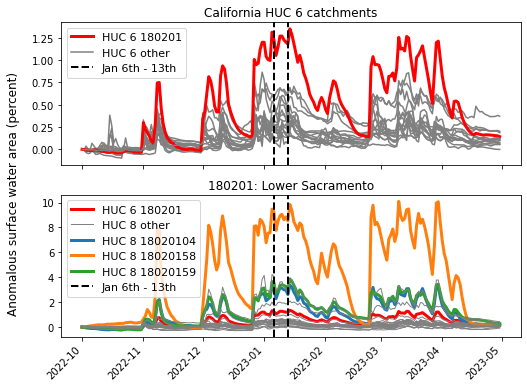

In [13]:
plot_area_or_fraction = "fraction"
y_label_unit = "fraction"
# Create a figure and two subplots, sharing the x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5.5), sharex=True)

# Plot for the first subplot
for column in df_huc6_nwmcnn_ts_anomaly.columns:
    if column != 180201:  # All other columns except '180201'
        ax1.plot(df_huc6_nwmcnn_ts_anomaly.index, df_huc6_nwmcnn_ts_anomaly[column], color='grey', label='_nolegend_')

# Plot the '180201' column in red on the first subplot and add a label for the legend.
ax1.plot(df_huc6_nwmcnn_ts_anomaly.index, df_huc6_nwmcnn_ts_anomaly[180201], color='red', label='HUC 6 180201', lw=3)
# Plot a grey line again for the common legend entry "HUC 6 catchment".
ax1.plot(df_huc6_nwmcnn_ts_anomaly.index, df_huc6_nwmcnn_ts_anomaly.iloc[:, 0], color='grey', label='HUC 6 other')

# Setting the legend for the first subplot
ax1.legend(fontsize="11")
ax1.set_title("California HUC 6 catchments")
#    ax1.set_ylabel("Anomalous surface water area (percent)")

# Plotting for the second subplot
for huc6_int in df_huc6_nwmcnn_ts_anomaly.columns.values:

    if huc6_int != 180201:
        continue

    huc6_str = str(huc6_int)
    huc6_name = shp_huc6[shp_huc6["huc6"]==huc6_str]["name"].values[0]
    huc6_area = shp_huc6[shp_huc6["huc6"]==huc6_str]["areasqkm"].values[0]

    if plot_area_or_fraction == "area":
        plot_this_huc6 = df_huc6_nwmcnn_ts_anomaly[huc6_int] * huc6_area
    elif plot_area_or_fraction == "fraction":
        plot_this_huc6 = df_huc6_nwmcnn_ts_anomaly[huc6_int]
    
    ax2.plot(plot_this_huc6.index, plot_this_huc6, label=f"HUC 6 {huc6_str}", c="r", lw=3)

    first_huc8 = True
    for huc8_int in df_huc8_nwmcnn_ts_anomaly.columns.values:
        huc8_str = str(huc8_int)
        if huc6_str == str(huc8_str)[:6]:
            if plot_area_or_fraction == "area":
                plot_this_huc8 = df_huc8_nwmcnn_ts_anomaly[huc8_int] * huc6_area
            elif plot_area_or_fraction == "fraction":
                plot_this_huc8 = df_huc8_nwmcnn_ts_anomaly[huc8_int]

            if huc8_int in [18020158, 18020104, 18020159]:
                ax2.plot(plot_this_huc8.index, plot_this_huc8, label=f"HUC 8 {huc8_int}", lw=3)            
            elif first_huc8:
                ax2.plot(plot_this_huc8.index, plot_this_huc8, label=f"HUC 8 other", c="grey", lw=1)
                first_huc8 = False
            else:
                ax2.plot(plot_this_huc8.index, plot_this_huc8, c="grey", lw=1)

# Add vertical lines for specific dates
jan6 = pd.Timestamp('2023-01-06')
jan13 = pd.Timestamp('2023-01-13')

# Add the vertical lines to both subplots
for ax in [ax1, ax2]:
    ax.axvline(jan6, color='k', linestyle='--', lw=2, label='Jan 6th - 13th')
    ax.axvline(jan13, color='k', linestyle='--', lw=2)



# Add a common y-axis label for the entire figure
fig.text(-0.04, 0.5, 'Anomalous surface water area (percent)', va='center', rotation='vertical', fontsize=12)


# Adjust the legends to include the new lines
ax1.legend(fontsize="11")
ax2.legend(fontsize=11)

# Setting the labels and title for the second subplot
#    ax2.set_ylabel(f"Anomalous surface area (percent)")
ax2.set_title(f"{huc6_str}: {huc6_name}")

# Legend for the second subplot
ax2.legend(fontsize=11)

# Rotate x-ticks for both subplots
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Use tight layout to arrange subplots to fit into the figure area.
plt.tight_layout()

# Save the figure
#plt.savefig("./figures/anomalous_surface_water_time_series.png", dpi=600)
plt.show()

# Close the plot
plt.close()